In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_csv("../data/crop_recommendation.csv")  # Adjust path if needed
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
print(df.isnull().sum())  # Ensure no missing values

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [5]:
df.duplicated().sum()

0

In [6]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

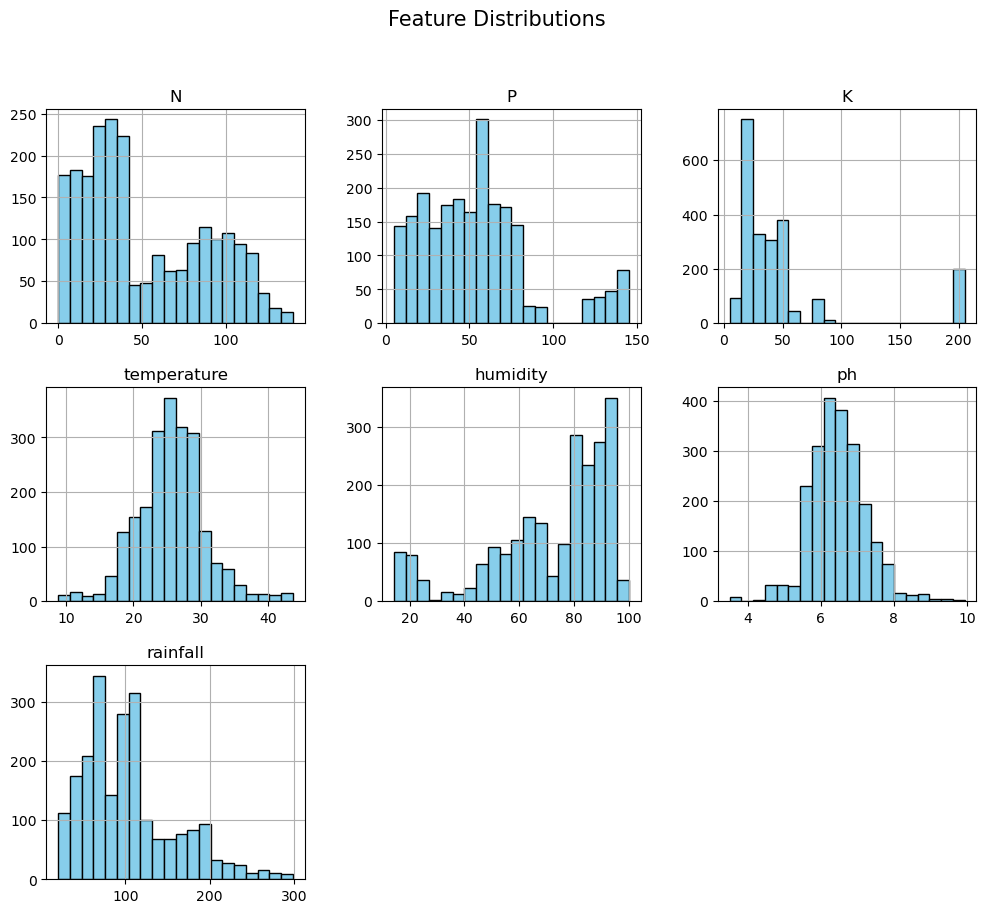

In [7]:
df.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=15)
plt.savefig("cr_feature_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\SOWMYA\AppData\Local\Temp\ipykernel_17320\4288250912.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette='viridis')


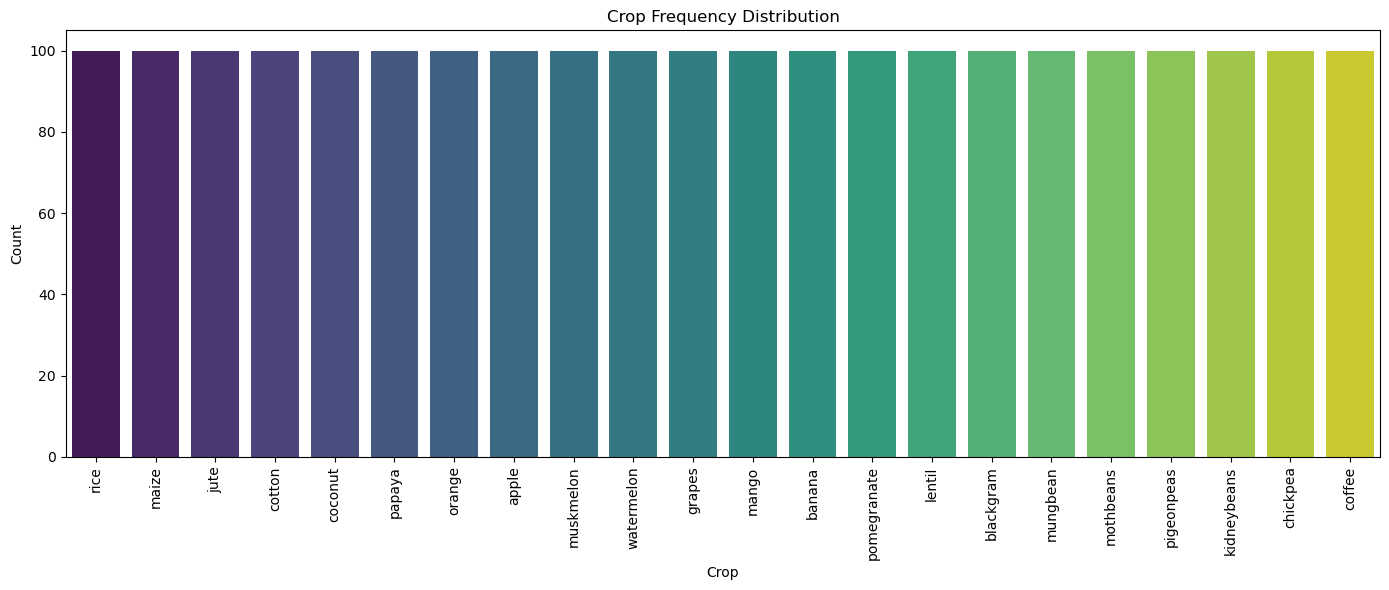

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette='viridis')
plt.xticks(rotation=90)
plt.title("Crop Frequency Distribution")
plt.xlabel("Crop")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("cr_crop_frequency.png", dpi=300, bbox_inches='tight')
plt.show()


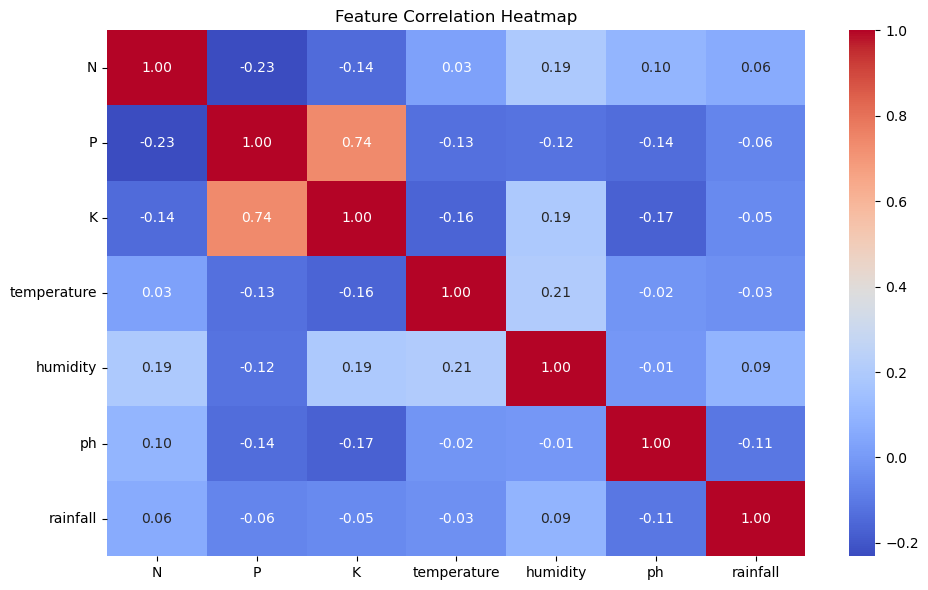

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop('label', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("cr_correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


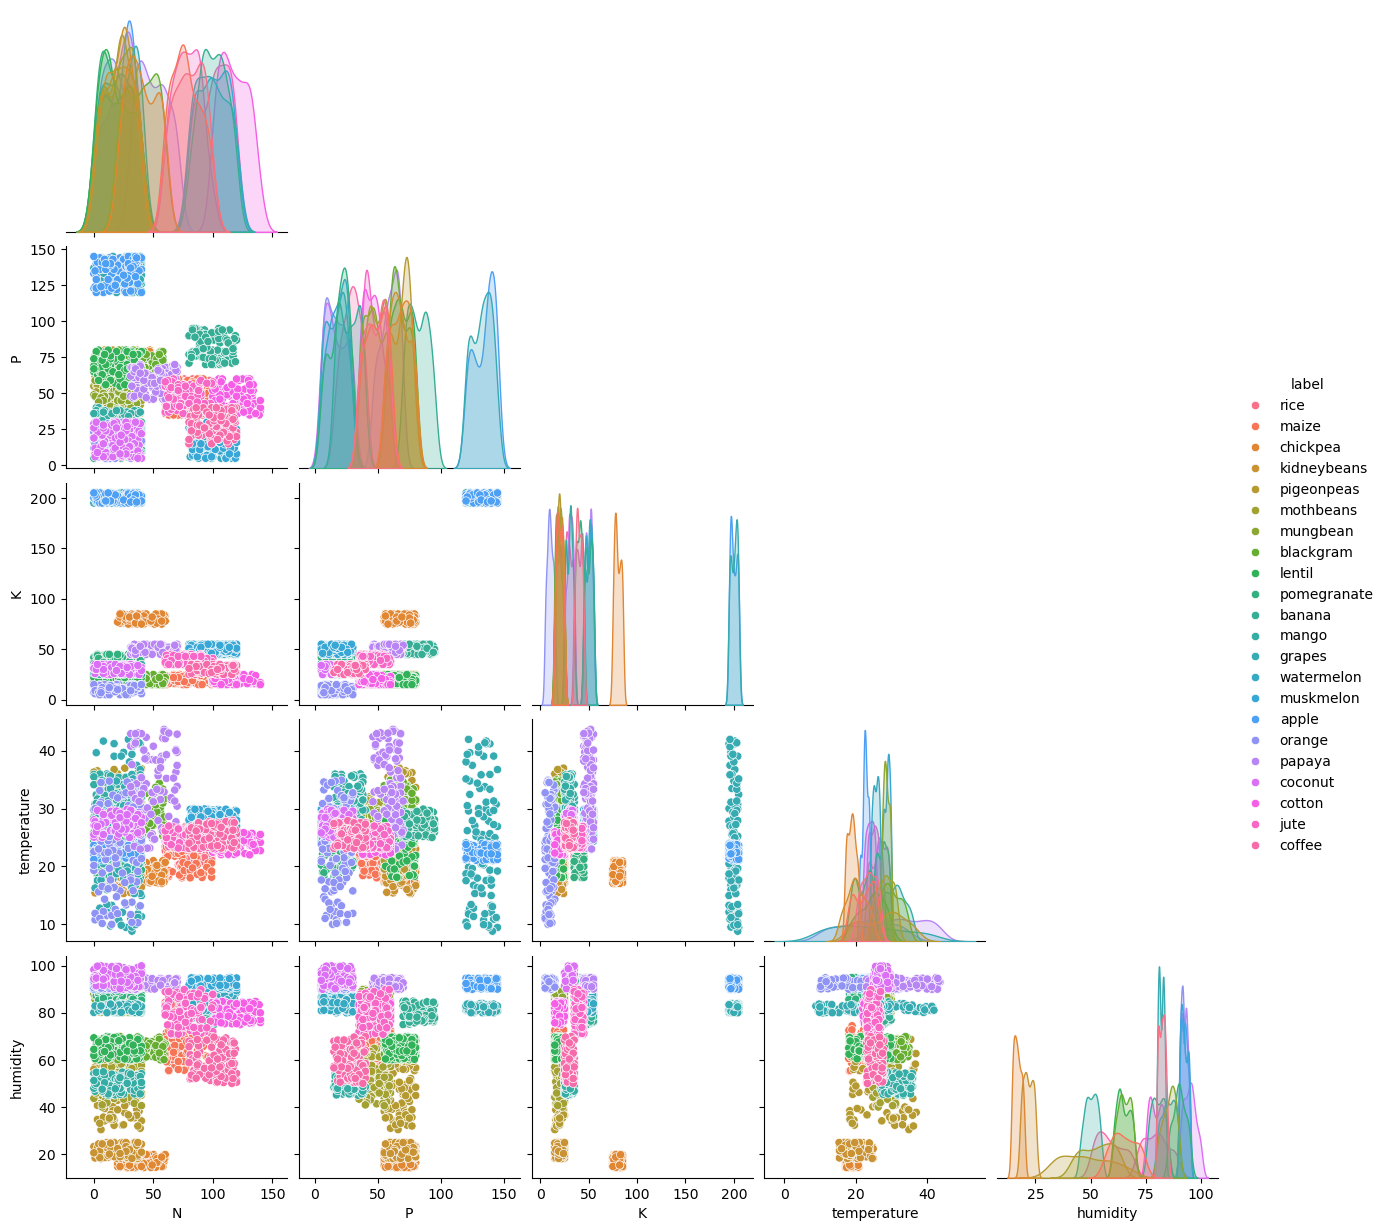

In [10]:
selected_features = ['N', 'P', 'K', 'temperature', 'humidity', 'label']
sns.pairplot(df[selected_features], hue='label', corner=True)
plt.savefig("cr_pariplot.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode crop labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

# Save encoder for later use
import pickle
with open("../models/crop_label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

crop_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(crop_mapping)  # This will help when decoding predictions later


{'apple': 0, 'banana': 1, 'blackgram': 2, 'chickpea': 3, 'coconut': 4, 'coffee': 5, 'cotton': 6, 'grapes': 7, 'jute': 8, 'kidneybeans': 9, 'lentil': 10, 'maize': 11, 'mango': 12, 'mothbeans': 13, 'mungbean': 14, 'muskmelon': 15, 'orange': 16, 'papaya': 17, 'pigeonpeas': 18, 'pomegranate': 19, 'rice': 20, 'watermelon': 21}


In [12]:
from sklearn.model_selection import train_test_split

# Define input features and target variable
X = df.drop(columns=['label'])  # Features (N, P, K, pH, humidity, temperature, rainfall)
y = df['label']  # Target (crop)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (1760, 7)
Testing set size: (440, 7)


In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Train and evaluate models
best_model = None
best_accuracy = 0
results = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    
    # Predictions
    y_train_pred = model.predict(X_train)  # Training predictions
    y_test_pred = model.predict(X_test)  # Testing predictions

    # Calculate accuracy
    test_acc = accuracy_score(y_test, y_test_pred) * 100

    # Classification report
    report = classification_report(y_test, y_test_pred, output_dict=True)  
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]


    results.append([name, test_acc, precision, recall, f1_score])

    # Save best model based on test accuracy
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = model

# Convert results to DataFrame and print
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)


c:\Users\SOWMYA\anaconda3\envs\crop_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\SOWMYA\anaconda3\envs\crop_env\lib\site-packages\xgboost\core.py:158: UserWarning: [14:28:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Test Accuracy  Precision    Recall  F1-Score
0          Naive Bayes      99.545455   0.995818  0.995455  0.995423
1        Random Forest      99.318182   0.993735  0.993182  0.993175
2                  SVM      97.954545   0.979847  0.979545  0.979308
3  Logistic Regression      94.090909   0.942611  0.940909  0.940937
4        Decision Tree      98.181818   0.982402  0.981818  0.981827
5              XGBoost      98.636364   0.986901  0.986364  0.986347


In [14]:
import pickle

# Save the trained Linear Regression model (or whichever model is best)
with open("../models/best_crop_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best model saved successfully as 'best_crop_model.pkl'.")
print(best_model)


Best model saved successfully as 'best_crop_model.pkl'.
GaussianNB()
